In [1]:
%config InlineBackend.figure_format = 'png'
import pandas as pd
from glob import glob
import datetime
# from pyproj import Transformer
# import wradlib as wrl
import re
from missingno import matrix

import scipy
import numpy as np
from scipy.sparse import load_npz,save_npz
import matplotlib.pyplot as plt
DIR_data = 'C:/Users/sverrirhd/vedurgogn/'

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.lib.stride_tricks import sliding_window_view


ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# # # For working with coordinates
# # transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
# # transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

# # URLS
# URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
# URL_gauge_2020_file = URL_gauge_data + 'clean2020data1475.csv'
# URL_saved_sensor_data = URL_gauge_data + 'hbs_lysigogn.csv'
# DIR_rain_gauges = glob(URL_gauge_data + '*cleaned*')

# DIR_data = 'C:/Users/sverrirhd/vedurgogn/'
# URL_dates = glob(DIR_data + '??_file_dates.npy')
# URL_missing_indexes = glob(DIR_data + '??_missing_indexes.npy')
# URL_pixel_coords_save = DIR_data + 'radar_pixel_coords.npy'

# def get_dates(URL):
#     dates = np.load(URL,allow_pickle=True)
#     return dates

# def get_missing(URL):
#     missing_indexes = np.load(URL)
#     return missing_indexes

# # def to_rainfall(radar_data):
# #     return wrl.zr.z_to_r(wrl.trafo.idecibel(offset + gain * radar_data), a=200, b=1.6)

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

# Generate noisy observations from a known function at some random points.
observation_noise_variance = .5
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)
observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = (f(observation_index_points) +
                np.random.normal(0., np.sqrt(observation_noise_variance)))

index_points = np.linspace(-1., 1., 100)[..., np.newaxis]

kernel = psd_kernels.MaternFiveHalves()

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10)
# ==> 10 independently drawn, joint samples at `index_points`.

Step 0: NLL = 930.2574089070829
Step 100: NLL = -26.368028644897358
Step 200: NLL = -33.1861534562648
Step 300: NLL = -39.48463406192295
Step 400: NLL = -41.73862705762727
Step 500: NLL = -41.85174825347633
Step 600: NLL = -41.85201243779514
Step 700: NLL = -41.8520124438875
Step 800: NLL = -41.852012443887446
Step 900: NLL = -41.85201239879359
Final NLL = -41.8520124438874


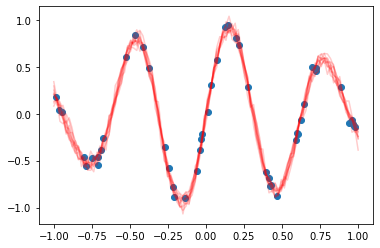

In [2]:
# Suppose we have some data from a known function. Note the index points in
# general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one
# here).
f = lambda x: np.sin(10*x[..., 0]) * np.exp(-x[..., 0]**2)

observation_index_points = np.random.uniform(-1., 1., 50)[..., np.newaxis]
observations = f(observation_index_points) + np.random.normal(0., .05, 50)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the same parameters, which we'll optimize below).
index_points = np.linspace(-1., 1., 100)[..., np.newaxis]
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# First train the model, then draw and plot posterior samples.
for i in range(1000):
  neg_log_likelihood_ = optimize()
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

samples = gprm.sample(10).numpy()
# ==> 10 independently drawn, joint samples at `index_points`.

import matplotlib.pyplot as plt
plt.scatter(np.squeeze(observation_index_points), observations)
plt.plot(np.stack([index_points[:, 0]]*10).T, samples.T, c='r', alpha=.2)

In [19]:
index_points = np.linspace(0)

array([[-1.        ],
       [-0.97979798],
       [-0.95959596],
       [-0.93939394],
       [-0.91919192],
       [-0.8989899 ],
       [-0.87878788],
       [-0.85858586],
       [-0.83838384],
       [-0.81818182],
       [-0.7979798 ],
       [-0.77777778],
       [-0.75757576],
       [-0.73737374],
       [-0.71717172],
       [-0.6969697 ],
       [-0.67676768],
       [-0.65656566],
       [-0.63636364],
       [-0.61616162],
       [-0.5959596 ],
       [-0.57575758],
       [-0.55555556],
       [-0.53535354],
       [-0.51515152],
       [-0.49494949],
       [-0.47474747],
       [-0.45454545],
       [-0.43434343],
       [-0.41414141],
       [-0.39393939],
       [-0.37373737],
       [-0.35353535],
       [-0.33333333],
       [-0.31313131],
       [-0.29292929],
       [-0.27272727],
       [-0.25252525],
       [-0.23232323],
       [-0.21212121],
       [-0.19191919],
       [-0.17171717],
       [-0.15151515],
       [-0.13131313],
       [-0.11111111],
       [-0

In [13]:


observation_noise_variance = tfp.util.TransformedVariable(np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# Kernel function
amplitude = tfp.util.TransformedVariable( 1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable( 1., tfb.Exp(), dtype=tf.float64, name='length_scale')

kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

kernel
# observation variance
index_points = 
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=input_sequences,
    observations=output_sequences,
    observation_noise_variance=observation_noise_variance)

NameError: name 'input_sequences' is not defined

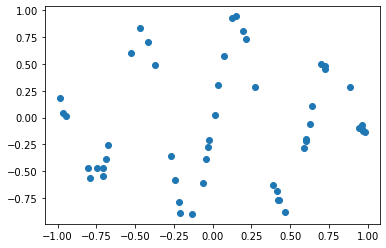

In [8]:
plt.scatter(observation_index_points,observations)

<TransformedVariable: dtype=float64, shape=[], fn="exp", numpy=0.0023263907298946055>

C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\sverrirhd\Anaconda3\envs\thesis\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


(array([653.08792288, 592.16905327]), array([316.68016218, 316.65121679]))

(500, 4)